Epoch 0 | Loss: 0.000582
Epoch 20 | Loss: 0.000517
Epoch 40 | Loss: 0.000491
Epoch 60 | Loss: 0.000337
Epoch 80 | Loss: 0.000055

Final RMSE: 40.89


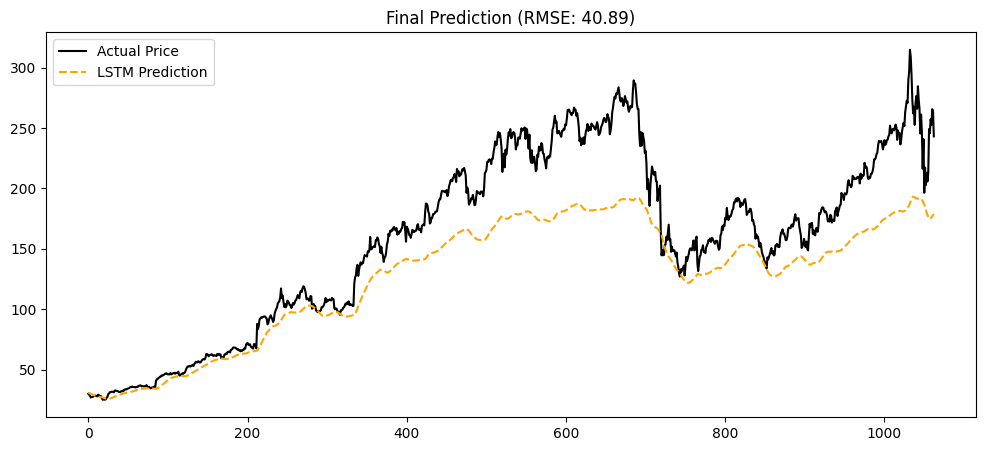

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# 1. טעינה וניקוי
df = pd.read_csv('NVDA.csv')
df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
df.dropna(subset=['Close'], inplace=True)
data = df['Close'].values.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        xs.append(data[i:(i + seq_length)])
        ys.append(data[i + seq_length])
    return np.array(xs), np.array(ys)

X, y = create_sequences(scaled_data, 20)
train_size = int(len(y) * 0.8)
X_train = torch.from_numpy(X[:train_size]).float()
y_train = torch.from_numpy(y[:train_size]).float()
X_test = torch.from_numpy(X[train_size:]).float()
y_test = torch.from_numpy(y[train_size:]).float()

# 2. מודל מאוזן (Balanced Model)
class BalancedLSTM(nn.Module):
    def __init__(self):
        super().__init__()
        # 128 נוירונים נותנים את הדיוק שראינו קודם
        self.lstm = nn.LSTM(1, 128, num_layers=2, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(128, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

model = BalancedLSTM()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# 3. אימון ממוקד (100 Epochs)
epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()
    if epoch % 20 == 0:
        print(f'Epoch {epoch} | Loss: {loss.item():.6f}')

# 4. הערכה
model.eval()
with torch.no_grad():
    preds = model(X_test).numpy()
    preds = scaler.inverse_transform(preds)
    actual = scaler.inverse_transform(y_test.numpy())

rmse = np.sqrt(np.mean((preds - actual)**2))
print(f'\nFinal RMSE: {rmse:.2f}')

# 5. גרפים להגשה
plt.figure(figsize=(12, 5))
plt.plot(actual, label='Actual Price', color='black', linewidth=1.5)
plt.plot(preds, label='LSTM Prediction', color='orange', linestyle='--')
plt.title(f'Final Prediction (RMSE: {rmse:.2f})')
plt.legend()
plt.show()